# Text metrics

An explanatory notebook to dive into text metrics usuable for a potential DiD.

In [1]:
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

from datetime import datetime, timedelta

sns.set_style("darkgrid")

# ChatGPT intro
treatment_date = datetime(2022, 11, 30)

## Stack Overflow metrics

In [2]:
df = pl.read_parquet("../data/batched_processing/stackoverflow_processed_batch.parquet")

In [3]:
df = (
    df.with_columns(
        pl.col("CreationDate").cast(pl.Datetime),
        pl.when(pl.col("tag_list").list.contains("python"))
        .then(pl.lit("Python"))
        .when(pl.col("tag_list").list.contains("r"))
        .then(pl.lit("R"))
        .when(pl.col("tag_list").list.contains("php"))
        .then(pl.lit("PHP"))
        .otherwise(pl.lit("JavaScript"))
        .alias("Lang"),
    )
    .with_columns(
        pl.col("CreationDate").dt.date().alias("date"),
        pl.col("CreationDate").dt.year().alias("year"),
        pl.col("CreationDate").dt.month().alias("month"),
        pl.col("CreationDate").dt.weekday().alias("day_of_week"),
        # ISO week of year
        pl.col("CreationDate").dt.week().alias("week"),
    )
    # Normalize (z-score) lengths
    .with_columns(
        (
            (pl.col("tag_count") - pl.col("tag_count").mean())
            / pl.col("tag_count").std()
        ).alias("norm_tag_count"),
        (
            (pl.col("code_length") - pl.col("code_length").mean())
            / pl.col("code_length").std()
        ).alias("norm_tech_expr_length"),
        (
            (pl.col("body_length") - pl.col("body_length").mean())
            / pl.col("body_length").std()
        ).alias("norm_body_length"),
        (
            (pl.col("title_length") - pl.col("title_length").mean())
            / pl.col("title_length").std()
        ).alias("norm_title_length"),
    )
    .with_columns(
        # Create a composite score
        (
            1
            / 4
            * (
                pl.col("norm_tag_count")
                + pl.col("norm_tech_expr_length")
                + pl.col("norm_body_length")
                + pl.col("norm_title_length")
            )
        ).alias("score")
    )
    .with_columns((pl.col("year") * 100 + pl.col("week")).alias("yearweek"))
)
# Aggregate over all languages
df0 = (
    df.group_by(["yearweek", "year", "week"])
    .agg(
        pl.len().alias("question_count"),
        pl.col("date").min().alias("week_start"),
        # Optional: additional metrics if you have them
        pl.col("norm_tag_count").mean().alias("mean_tag_count"),
        pl.col("norm_tech_expr_length").mean().alias("mean_tech_expr_length"),
        pl.col("norm_body_length").mean().alias("mean_body_length"),
        pl.col("norm_title_length").mean().alias("mean_title_length"),
        pl.col("score").mean().alias("mean_score"),
    )
    # Drop first week and last two as they are non-representative (determined during EDA)
    .filter(
        pl.col("week_start") > datetime(2021, 1, 1),
        pl.col("week_start") <= datetime(2024, 3, 4),
    )
)

In [4]:
pre_mean = (
    df0.filter(pl.col("week_start").lt(treatment_date))
    .select(["mean_score"])
    .mean()
    .item()
)
post_mean = (
    df0.filter(pl.col("week_start").gt(treatment_date))
    .select(["mean_score"])
    .mean()
    .item()
)

# First, get the date range information
date_min = df0["week_start"].min()
date_max = df0["week_start"].max()

# Calculate the normalized position of the treatment date
treatment_pos = (treatment_date.date() + timedelta(days=-7) - date_min) / (
    date_max - date_min
)

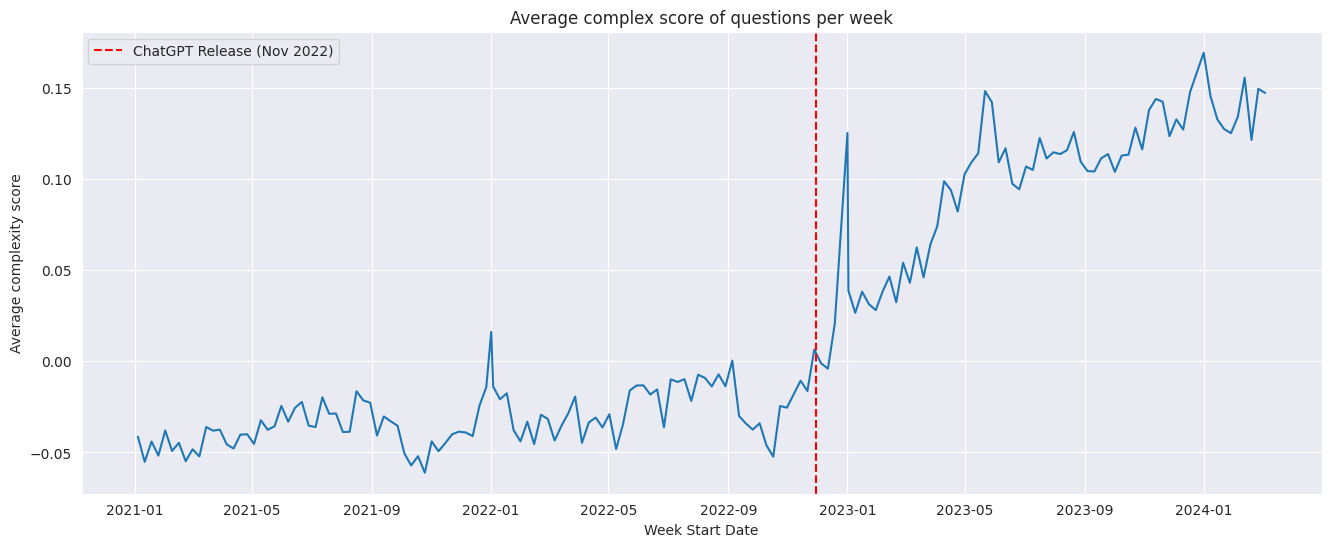

In [5]:
# Line plots of average lengths
plt.figure(figsize=(16, 6))
sns.lineplot(data=df0, x="week_start", y="mean_score")
# Add a vertical line for ChatGPT release
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
plt.title("Average complex score of questions per week")
plt.xlabel("Week Start Date")
plt.ylabel("Average complexity score")
plt.legend()
plt.show()

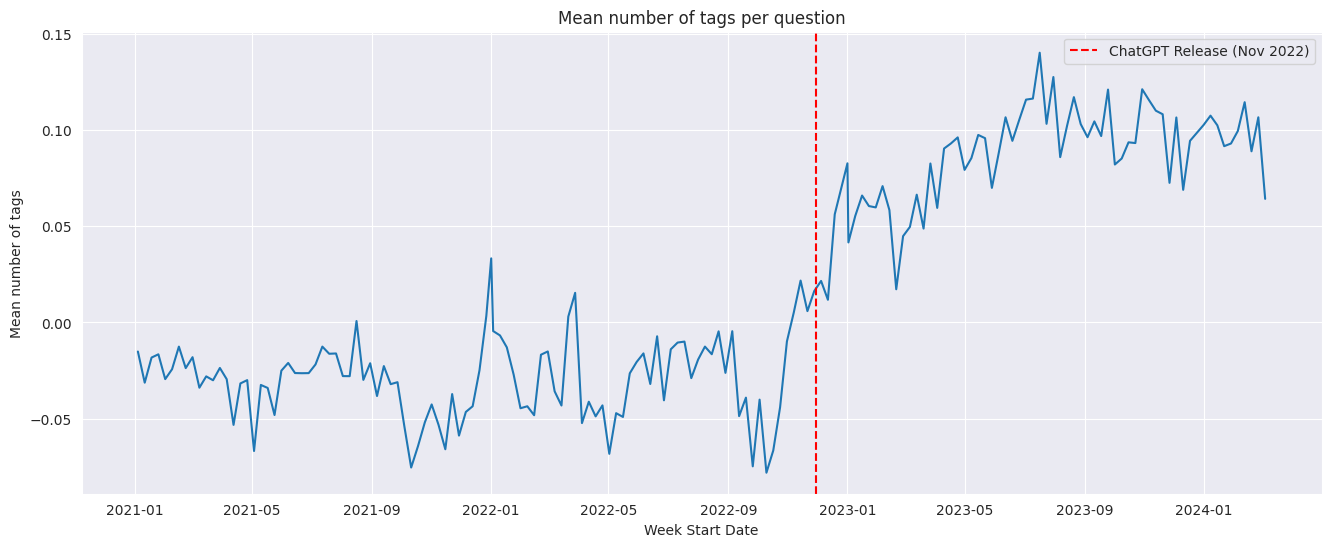

In [6]:
# Line plots of average lengths
plt.figure(figsize=(16, 6))
sns.lineplot(data=df0, x="week_start", y="mean_tag_count")
# Add a vertical line for ChatGPT release
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
plt.title("Mean number of tags per question")
plt.xlabel("Week Start Date")
plt.ylabel("Mean number of tags")
plt.legend()
plt.show()

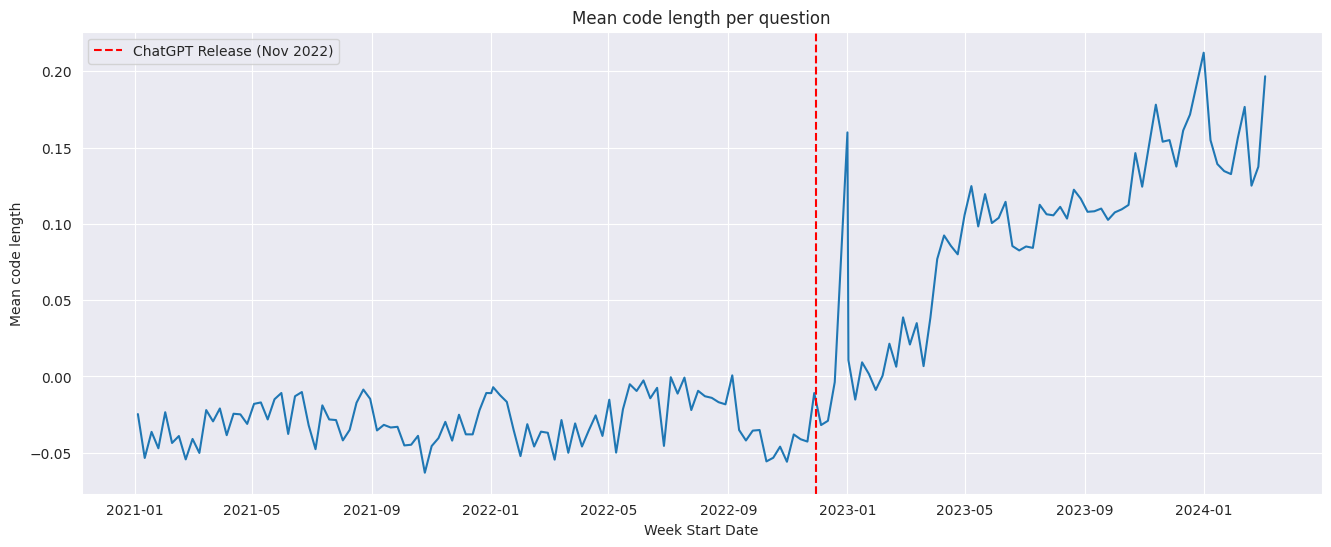

In [7]:
# Line plots of average lengths
plt.figure(figsize=(16, 6))
sns.lineplot(data=df0, x="week_start", y="mean_tech_expr_length")
# Add a vertical line for ChatGPT release
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
plt.title("Mean code length per question")
plt.xlabel("Week Start Date")
plt.ylabel("Mean code length")
plt.legend()
plt.show()

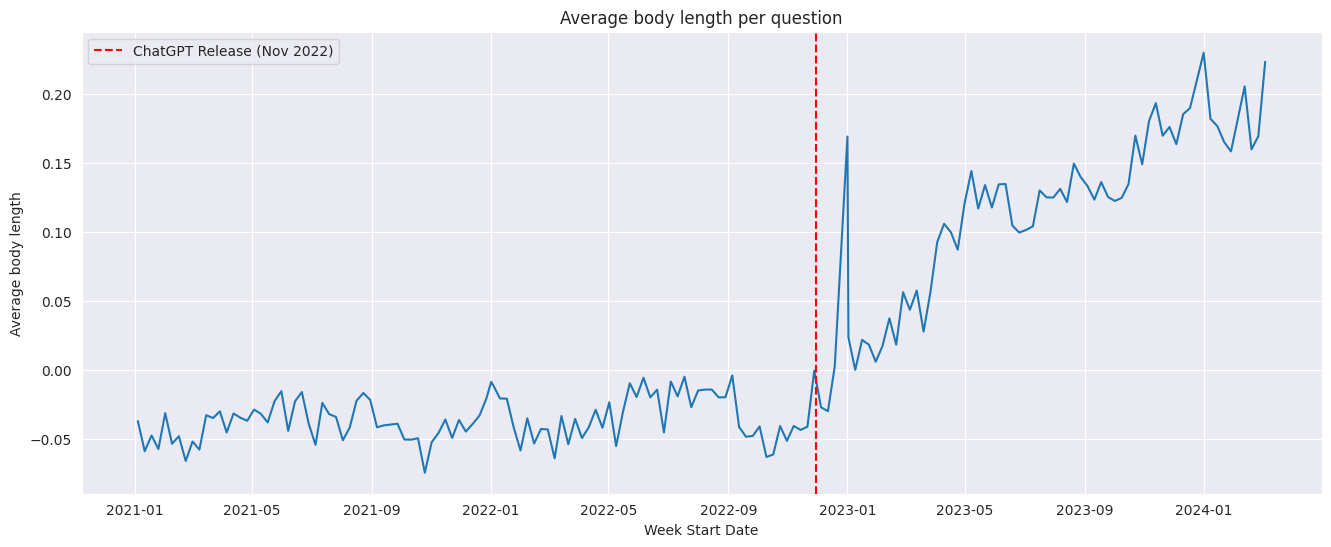

In [8]:
# Line plots of average lengths
plt.figure(figsize=(16, 6))
sns.lineplot(data=df0, x="week_start", y="mean_body_length")
# Add a vertical line for ChatGPT release
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
plt.title("Average body length per question")
plt.xlabel("Week Start Date")
plt.ylabel("Average body length")
plt.legend()
plt.show()

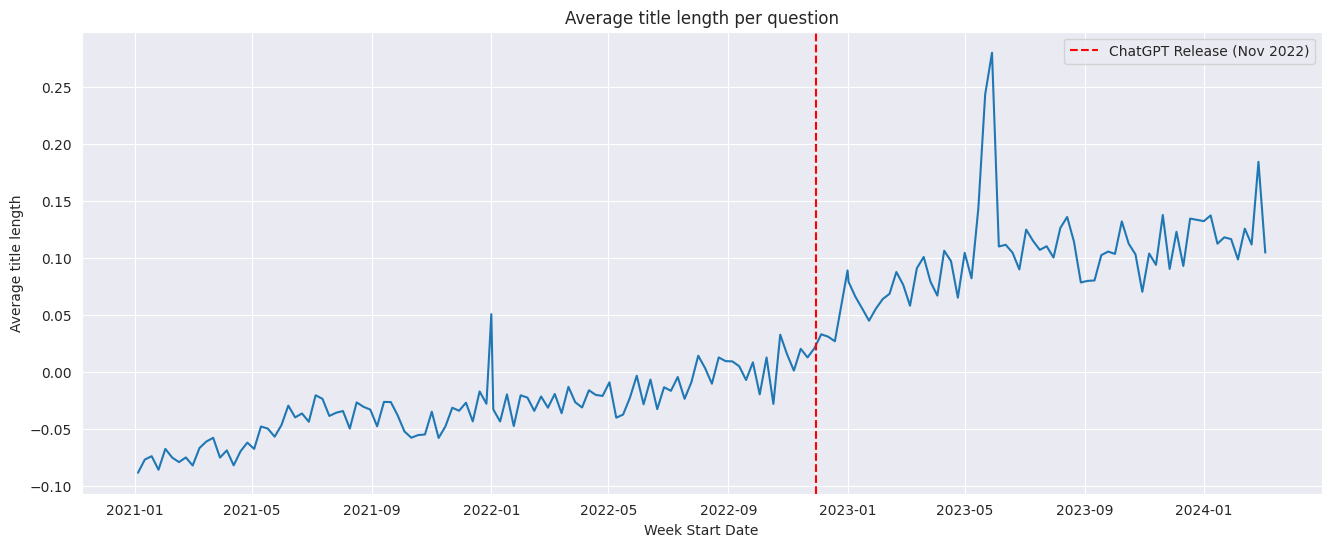

In [9]:
# Line plots of average lengths
plt.figure(figsize=(16, 6))
sns.lineplot(data=df0, x="week_start", y="mean_title_length")
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
plt.title("Average title length per question")
plt.xlabel("Week Start Date")
plt.ylabel("Average title length")
plt.legend()
plt.show()

## By Language

In [10]:
df1 = (
    df.group_by(["yearweek", "year", "week", "Lang"])
    .agg(
        pl.len().alias("question_count"),
        pl.col("date").min().alias("week_start"),
        # Optional: additional metrics if you have them
        pl.col("norm_tag_count").mean().alias("mean_tag_count"),
        pl.col("norm_tech_expr_length").mean().alias("mean_tech_expr_length"),
        pl.col("norm_body_length").mean().alias("mean_body_length"),
        pl.col("norm_title_length").mean().alias("mean_title_length"),
        pl.col("score").mean().alias("mean_score"),
    )
    # Drop first week and last two as they are non-representative (determined during EDA)
    .filter(
        pl.col("week_start") > datetime(2021, 1, 1),
        pl.col("week_start") <= datetime(2024, 3, 4),
    )
)

In [11]:
pre_mean = (
    df1.filter(pl.col("week_start").lt(treatment_date))
    .select(["mean_score"])
    .mean()
    .item()
)
post_mean = (
    df1.filter(pl.col("week_start").gt(treatment_date))
    .select(["mean_score"])
    .mean()
    .item()
)

# First, get the date range information
date_min = df1["week_start"].min()
date_max = df1["week_start"].max()

# Calculate the normalized position of the treatment date
treatment_pos = (treatment_date.date() + timedelta(days=-7) - date_min) / (
    date_max - date_min
)

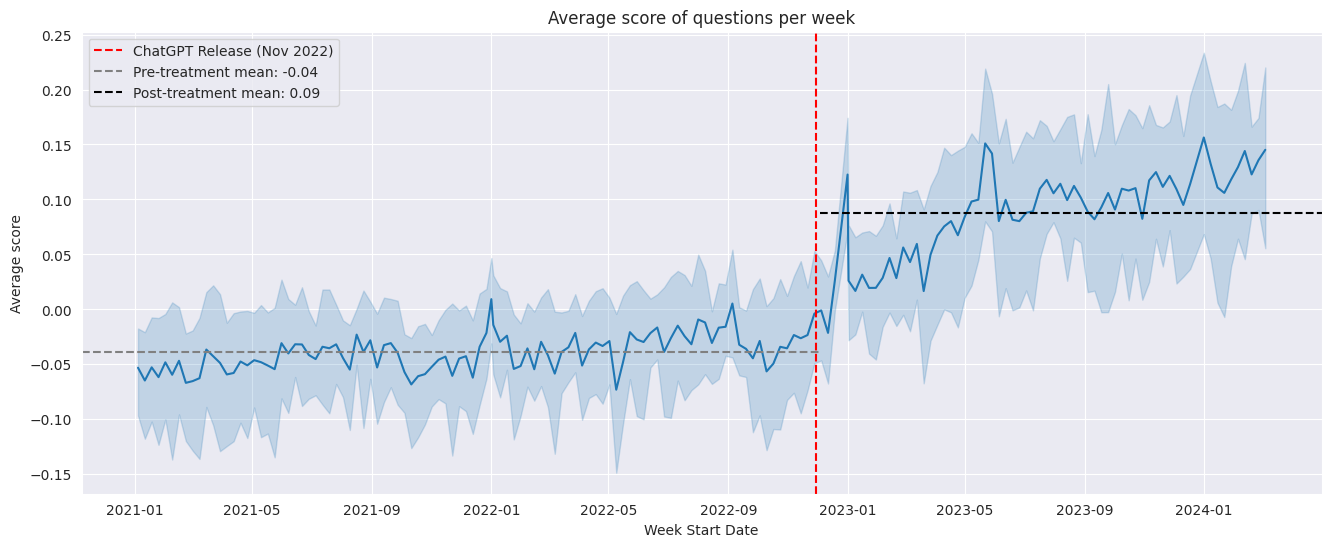

In [12]:
# Line plots of average lengths
plt.figure(figsize=(16, 6))
sns.lineplot(data=df1, x="week_start", y="mean_score")
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
# Mean pre-treat
plt.axhline(
    y=pre_mean,
    xmax=treatment_pos,
    color="grey",
    linestyle="--",
    label=f"Pre-treatment mean: {pre_mean:.2f}",
)
# Mean post-treat
plt.axhline(
    y=post_mean,
    xmin=treatment_pos,
    color="black",
    linestyle="--",
    label=f"Post-treatment mean: {post_mean:.2f}",
)
plt.title("Average score of questions per week")
plt.xlabel("Week Start Date")
plt.ylabel("Average score")
plt.legend()
plt.show()

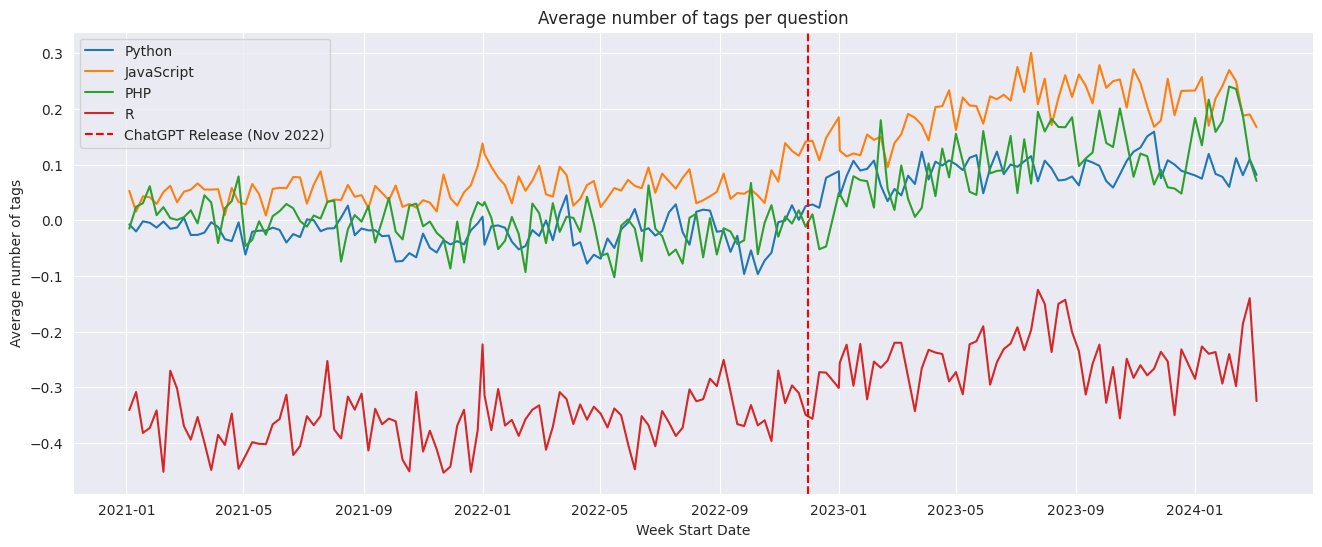

In [13]:
# Line plots of average lengths
plt.figure(figsize=(16, 6))
sns.lineplot(data=df1, x="week_start", y="mean_tag_count", hue="Lang")
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
plt.title("Average number of tags per question")
plt.xlabel("Week Start Date")
plt.ylabel("Average number of tags")
plt.legend()
plt.show()

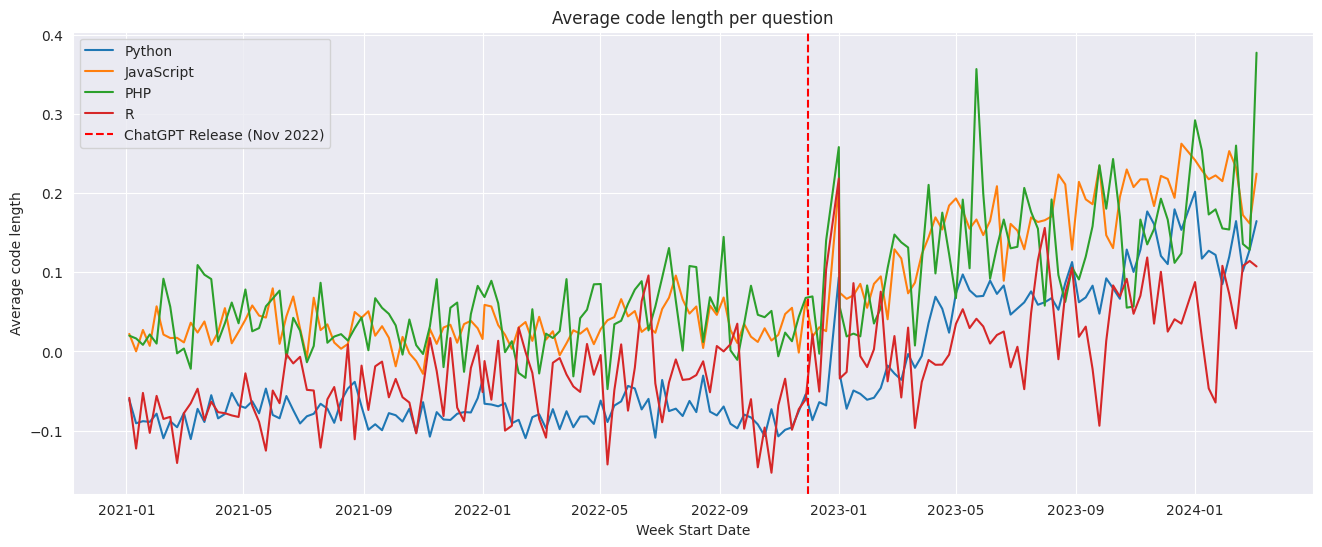

In [14]:
# Line plots of average lengths
plt.figure(figsize=(16, 6))
sns.lineplot(data=df1, x="week_start", y="mean_tech_expr_length", hue="Lang")
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
plt.title("Average code length per question")
plt.xlabel("Week Start Date")
plt.ylabel("Average code length")
plt.legend()
plt.show()

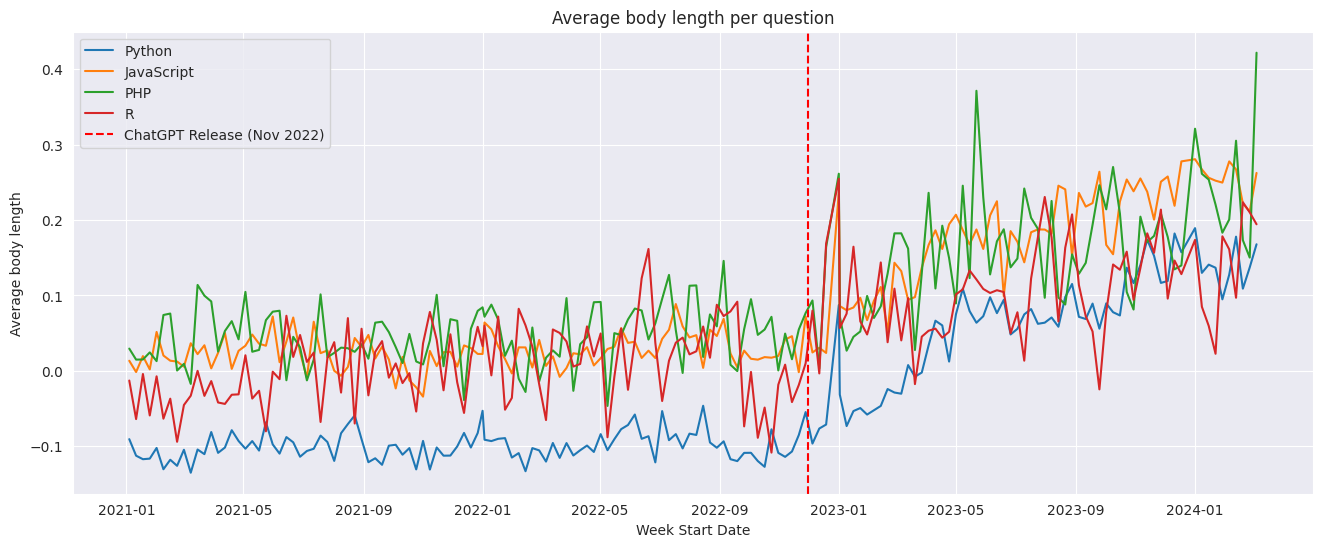

In [15]:
# Line plots of average lengths
plt.figure(figsize=(16, 6))
sns.lineplot(data=df1, x="week_start", y="mean_body_length", hue="Lang")
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
plt.title("Average body length per question")
plt.xlabel("Week Start Date")
plt.ylabel("Average body length")
plt.legend()
plt.show()

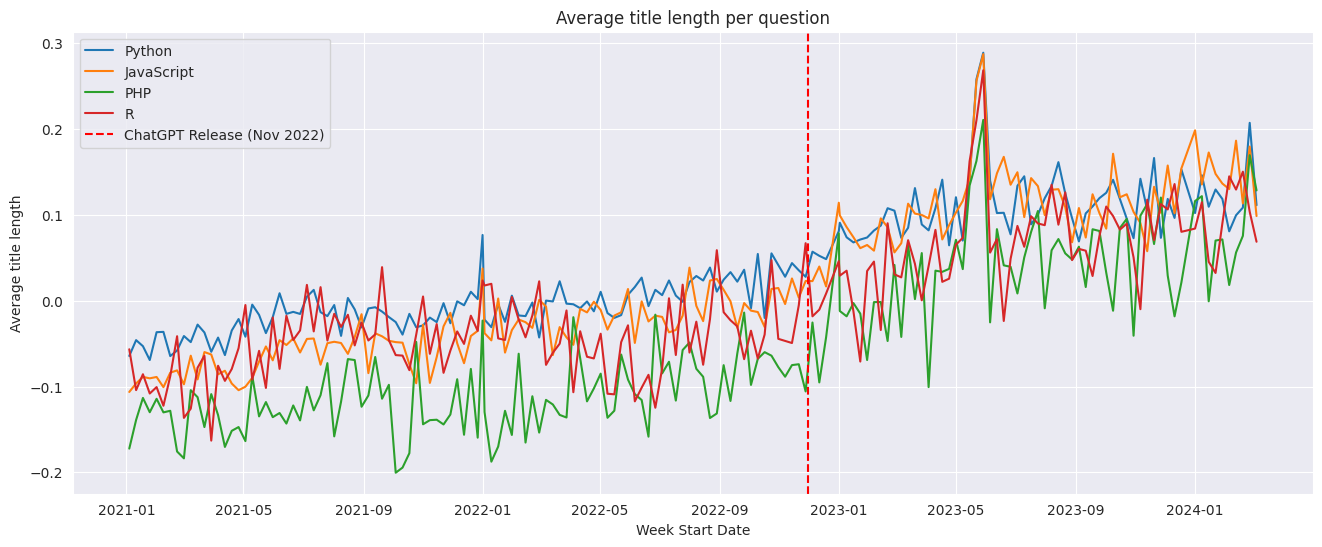

In [16]:
# Line plots of average lengths
plt.figure(figsize=(16, 6))
sns.lineplot(data=df1, x="week_start", y="mean_title_length", hue="Lang")
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
plt.title("Average title length per question")
plt.xlabel("Week Start Date")
plt.ylabel("Average title length")
plt.legend()
plt.show()

## Comparative metrics for other StackExchanges

In [17]:
df2 = pl.read_parquet("../data/batched_processing/forums_wo_so_processed_batch.parquet")

In [18]:
df2.shape

(514453, 16)

In [19]:
df2 = (
    df2.with_columns(
        pl.col("CreationDate").cast(pl.Datetime),
    )
    .with_columns(
        pl.col("CreationDate").dt.date().alias("date"),
        pl.col("CreationDate").dt.year().alias("year"),
        pl.col("CreationDate").dt.month().alias("month"),
        pl.col("CreationDate").dt.weekday().alias("day_of_week"),
        # ISO week of year
        pl.col("CreationDate").dt.week().alias("week"),
    )
    # Normalize (z-score) lengths
    .with_columns(
        (
            (pl.col("tag_count") - pl.col("tag_count").mean())
            / pl.col("tag_count").std()
        ).alias("norm_tag_count"),
        (
            (pl.col("body_length") - pl.col("body_length").mean())
            / pl.col("body_length").std()
        ).alias("norm_body_length"),
        (
            (pl.col("title_length") - pl.col("title_length").mean())
            / pl.col("title_length").std()
        ).alias("norm_title_length"),
        (
            (pl.col("expr_length") - pl.col("expr_length").mean())
            / pl.col("expr_length").std()
        ).alias("norm_tech_expr_length"),
    )
    .with_columns(
        # Create a composite score
        (
            1
            / 4
            * (
                pl.col("norm_tag_count")
                + pl.col("norm_body_length")
                + pl.col("norm_title_length")
                + pl.col("norm_tech_expr_length")
            )
        ).alias("score")
    )
    .with_columns((pl.col("year") * 100 + pl.col("week")).alias("yearweek"))
    .group_by(["yearweek", "year", "week", "forum"])
    .agg(
        pl.len().alias("question_count"),
        pl.col("date").min().alias("week_start"),
        # Optional: additional metrics if we have them
        pl.col("norm_tag_count").mean().alias("mean_tag_count"),
        pl.col("norm_body_length").mean().alias("mean_body_length"),
        pl.col("norm_title_length").mean().alias("mean_title_length"),
        pl.col("norm_tech_expr_length").mean().alias("mean_tech_expr_length"),
        pl.col("score").mean().alias("mean_score"),
    )
    # Drop first week and last two as they are non-representative (determined during EDA)
    .filter(
        pl.col("week_start") > datetime(2021, 1, 1),
        pl.col("week_start") <= datetime(2024, 3, 4),
    )
)

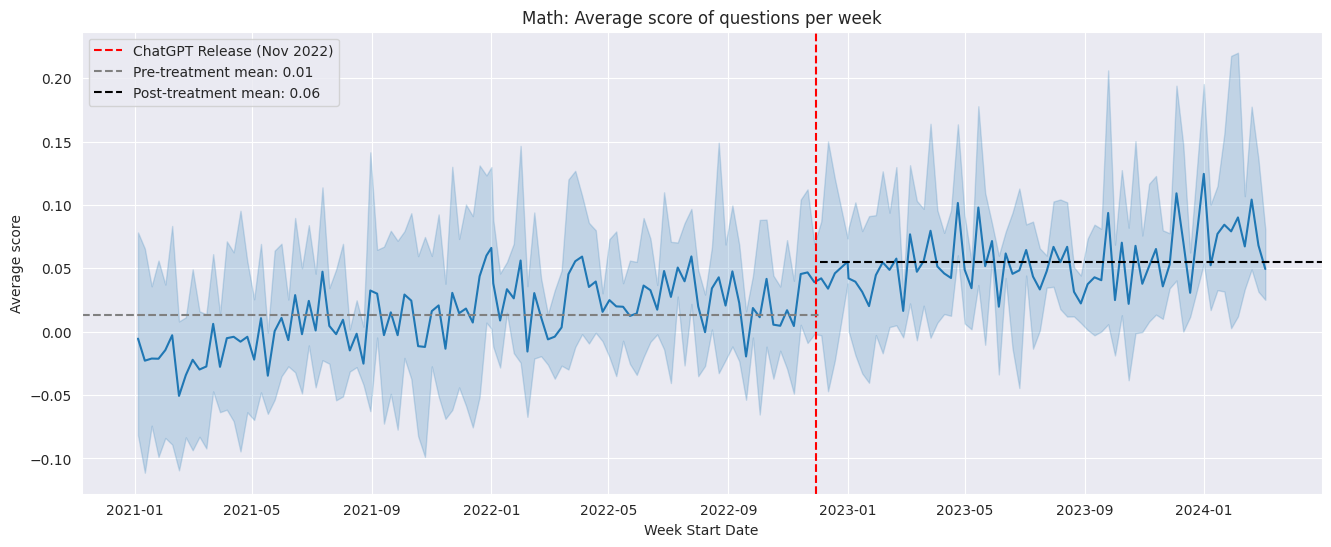

In [20]:
# Calculate the mean score before and after the treatment date
pre_mean = (
    df2.filter(pl.col("week_start").lt(treatment_date))
    .select(["mean_score"])
    .mean()
    .item()
)
post_mean = (
    df2.filter(pl.col("week_start").gt(treatment_date))
    .select(["mean_score"])
    .mean()
    .item()
)

# First, get the date range information
date_min = df2["week_start"].min()
date_max = df2["week_start"].max()

# Calculate the normalized position of the treatment date
treatment_pos = (treatment_date.date() + timedelta(days=-7) - date_min) / (
    date_max - date_min
)

# Line plots of average lengths
plt.figure(figsize=(16, 6))
sns.lineplot(data=df2, x="week_start", y="mean_score")
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
# Mean pre-treat
plt.axhline(
    y=pre_mean,
    xmax=treatment_pos,
    color="grey",
    linestyle="--",
    label=f"Pre-treatment mean: {pre_mean:.2f}",
)
# Mean post-treat
plt.axhline(
    y=post_mean,
    xmin=treatment_pos,
    color="black",
    linestyle="--",
    label=f"Post-treatment mean: {post_mean:.2f}",
)
plt.title("Math: Average score of questions per week")
plt.xlabel("Week Start Date")
plt.ylabel("Average score")
plt.legend()
plt.show()

## Combining all

In [21]:
df1 = df1.with_columns(
    pl.lit("Treatment").alias("Treatment"),
    pl.lit("Stack Overflow").alias("forum"),
)
df2 = df2.with_columns(pl.lit("Control").alias("Treatment"))
df_all = pl.concat([df1, df2], how="diagonal_relaxed")

In [22]:
df_all.shape

(1328, 13)

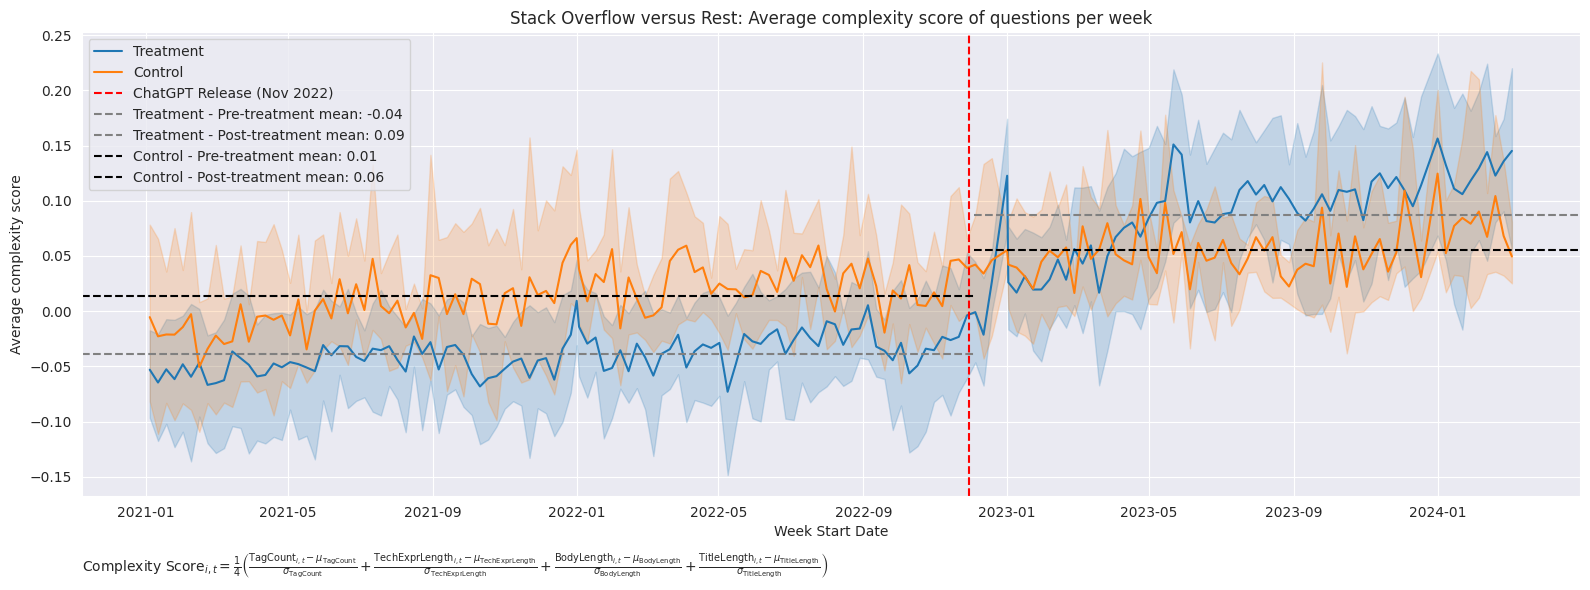

In [26]:
# Calculate the mean score before and after the treatment date
pre_mean_treat = (
    df_all.filter(
        pl.col("week_start").lt(treatment_date) & pl.col("Treatment").eq("Treatment")
    )
    .select(["mean_score"])
    .mean()
    .item()
)
post_mean_treat = (
    df_all.filter(
        pl.col("week_start").gt(treatment_date) & pl.col("Treatment").eq("Treatment")
    )
    .select(["mean_score"])
    .mean()
    .item()
)

pre_mean_control = (
    df_all.filter(
        pl.col("week_start").lt(treatment_date) & pl.col("Treatment").eq("Control")
    )
    .select(["mean_score"])
    .mean()
    .item()
)
post_mean_control = (
    df_all.filter(
        pl.col("week_start").gt(treatment_date) & pl.col("Treatment").eq("Control")
    )
    .select(["mean_score"])
    .mean()
    .item()
)

# First, get the date range information
date_min = df_all["week_start"].min()
date_max = df_all["week_start"].max()

# Calculate the normalized position of the treatment date
treatment_pos = (treatment_date.date() + timedelta(days=-7) - date_min) / (
    date_max - date_min
)

# Line plots of average lengths
plt.figure(figsize=(16, 6))
sns.lineplot(data=df_all, x="week_start", y="mean_score", hue="Treatment")
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
# Mean pre-treat
plt.axhline(
    y=pre_mean_treat,
    xmax=treatment_pos,
    color="grey",
    linestyle="--",
    label=f"Treatment - Pre-treatment mean: {pre_mean_treat:.2f}",
)
# Mean post-treat
plt.axhline(
    y=post_mean_treat,
    xmin=treatment_pos,
    color="grey",
    linestyle="--",
    label=f"Treatment - Post-treatment mean: {post_mean_treat:.2f}",
)
# Mean pre-treat
plt.axhline(
    y=pre_mean_control,
    xmax=treatment_pos,
    color="black",
    linestyle="--",
    label=f"Control - Pre-treatment mean: {pre_mean_control:.2f}",
)
# Mean post-treat
plt.axhline(
    y=post_mean_control,
    xmin=treatment_pos,
    color="black",
    linestyle="--",
    label=f"Control - Post-treatment mean: {post_mean_control:.2f}",
)
plt.title("Stack Overflow versus Rest: Average complexity score of questions per week")
plt.xlabel("Week Start Date")
plt.ylabel("Average complexity score")
plt.annotate(
    r"$\text{Complexity Score}_{i,t} = \frac{1}{4} \left( \frac{\text{TagCount}_{i,t} - \mu_{\text{TagCount}}}{\sigma_{\text{TagCount}}} + \frac{\text{TechExprLength}_{i,t} - \mu_{\text{TechExprLength}}}{\sigma_{\text{TechExprLength}}} + \frac{\text{BodyLength}_{i,t} - \mu_{\text{BodyLength}}}{\sigma_{\text{BodyLength}}} + \frac{\text{TitleLength}_{i,t} - \mu_{\text{TitleLength}}}{\sigma_{\text{TitleLength}}} \right)$",
    (0, 0),
    (0, -40),
    xycoords="axes fraction",
    textcoords="offset points",
    va="top",
)
plt.legend()
plt.tight_layout()
plt.savefig("../imgs/stackoverflow_vs_rest.svg")
plt.show()

In [24]:
# Save data for Stata analysis
df_stata = df_all.with_columns(
    pl.when(pl.col("forum").eq("Stack Overflow")).then(1).otherwise(0).alias("treated"),
    pl.when(pl.col("week_start").gt(treatment_date))
    .then(1)
    .otherwise(0)
    .alias("treatment"),
    pl.when(
        pl.col("week_start").gt(treatment_date) & pl.col("forum").eq("Stack Overflow")
    )
    .then(1)
    .otherwise(0)
    .alias("treatment_synthdid"),
    # Weeks indexed
    pl.col("week_start").rank(method="dense").sub(1).alias("week_index"),
    pl.when(pl.col("Lang").is_null())
    .then(pl.col("forum"))
    .otherwise(pl.col("Lang"))
    .alias("group"),
)

month_cont = (
    df_all.with_columns(
        # Month controls
        (pl.col("week_start").dt.year() * 100 + pl.col("week_start").dt.month()).alias(
            "year_month"
        )
    )
    .select("year_month")
    .to_dummies(drop_first=True)
)

quarter_cont = (
    df_all.with_columns(
        # Quarter controls
        (pl.col("week_start").dt.year() * 10 + pl.col("week_start").dt.quarter()).alias(
            "year_quarter"
        )
    )
    .select("year_quarter")
    .to_dummies(drop_first=True)
)

df_stata = pl.concat([df_stata, month_cont, quarter_cont], how="horizontal")

df_stata.drop("Treatment").to_pandas().to_stata("../data/stata/nlp.dta")